# Machine Learning: Customer Segmentation
I will divide this project into two parts.

Part 1: I will analyze the KPIs.

Part 2: I will use clustering algorithms Gaussian Mixture Model (GMM), and K-Means to segment customers. 

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import datetime as dt

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import os

In [2]:
dat = pd.read_csv("sales_data.csv", encoding = 'unicode_escape')

In [3]:
dat.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,CITY,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,NYC,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,Reims,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,Paris,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,Pasadena,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,San Francisco,USA,NaN,Brown,Julie,Medium


In [4]:
dat.shape

(2823, 20)

In [5]:
# Checking null values
dat.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
CITY                   0
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [6]:
# I will not be using 'TERRITORY' for any analysis
del dat["TERRITORY"]

In [7]:
dat.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [8]:
# Change 'ORDERDATE' from object to datetime
dat['ORDERDATE'] = pd.to_datetime(dat['ORDERDATE'])

In [9]:
# Time range of the data
dat.groupby(['YEAR_ID'])['MONTH_ID'].nunique()

YEAR_ID
2003    12
2004    12
2005     5
Name: MONTH_ID, dtype: int64

I am willing to exclude 2005 from the dataset. 

In [10]:
# Filter out the year 2005 
dat.drop(dat[dat['YEAR_ID'] == 2005].index, inplace = True) 

In [11]:
dat.groupby(['YEAR_ID'])['MONTH_ID'].nunique()

YEAR_ID
2003    12
2004    12
Name: MONTH_ID, dtype: int64

In [12]:
dat.shape

(2345, 19)

# Part 1: Analysis of KPIs

### Monthly Revenue

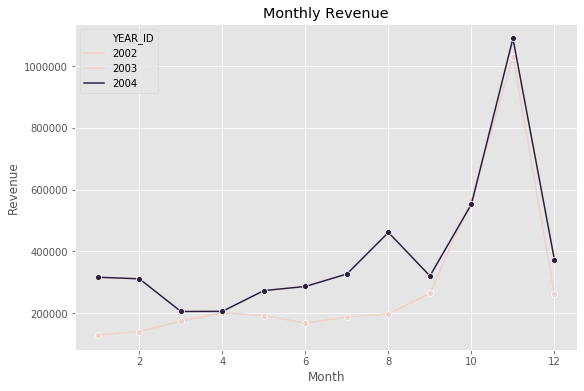

In [13]:
plt.figure(figsize=(9,6))
monthly_revenue = dat.groupby(['YEAR_ID','MONTH_ID'])['SALES'].sum().reset_index()
monthly_revenue
sns.lineplot(x="MONTH_ID", y="SALES",hue="YEAR_ID", marker="o", data=monthly_revenue)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')
plt.show()

We see that 2004 is performing better than 2003 up until September. However, the revenue is growing at a similar pace September onwards for both years.   

### Monthly Revenue Growth Rate 

In [14]:
monthly_revenue['MONTHLY GROWTH'] = monthly_revenue['SALES'].pct_change()
monthly_revenue.head()

,YEAR_ID,MONTH_ID,SALES,MONTHLY GROWTH
0,2003,1,129753.60,NaN
1,2003,2,140836.19,0.085413
2,2003,3,174504.90,0.239063
3,2003,4,201609.55,0.155323
4,2003,5,192673.11,-0.044325


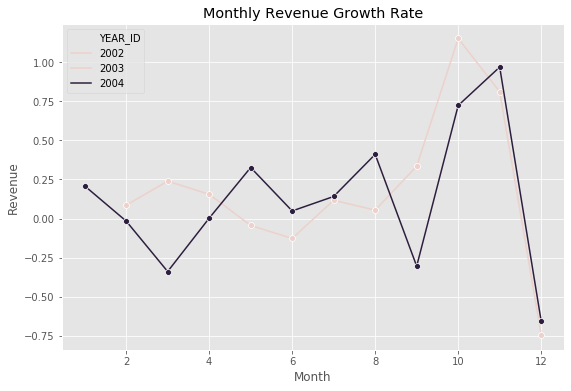

In [15]:
plt.figure(figsize=(9,6))
sns.lineplot(x="MONTH_ID", y="MONTHLY GROWTH",hue="YEAR_ID", marker="o", data=monthly_revenue)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue Growth Rate')
plt.show()

As expected, we see high growth rates September onwards. Apart from that, we see the highest decline in the growth rate in March 2004.

### Monthly Active Customers

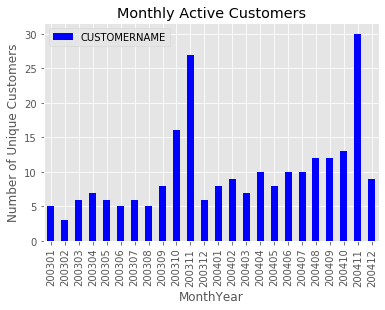

In [16]:
dat['YEAR_MONTH'] = dat['YEAR_ID'].map(str)+dat['MONTH_ID'].map(str).map(lambda x: x.rjust(2,'0'))
monthly_active = dat.groupby(['YEAR_MONTH'])['CUSTOMERNAME'].nunique().reset_index()
monthly_active.plot(kind='bar', color= 'Blue', x='YEAR_MONTH',y='CUSTOMERNAME')
plt.title('Monthly Active Customers')
plt.xlabel('MonthYear')
plt.ylabel('Number of Unique Customers')
plt.xticks(rotation=90)
plt.show()

We can clearly see that, the number of monthly active customers dropped in March from February 2004 which contributed to the lowest growth rate. We will see a similar trend for number of orders as well.

### Monthly Order Count

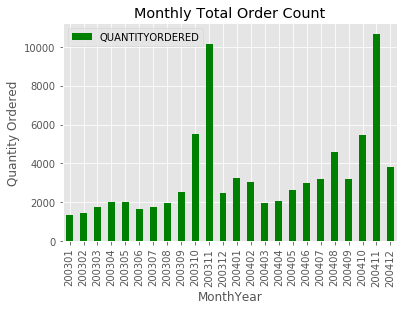

In [17]:
monthly_orders = dat.groupby('YEAR_MONTH')['QUANTITYORDERED'].sum().reset_index()
monthly_orders.plot(kind='bar', color= 'Green', x='YEAR_MONTH', y='QUANTITYORDERED')
plt.title('Monthly Total Order Count')
plt.xlabel('MonthYear')
plt.ylabel('Quantity Ordered')
plt.xticks(rotation=90)
plt.show()

As expected, the monthly order count also declined in March 2004 by 33% (from 3000 to 2000).

### Average Revenue per Order

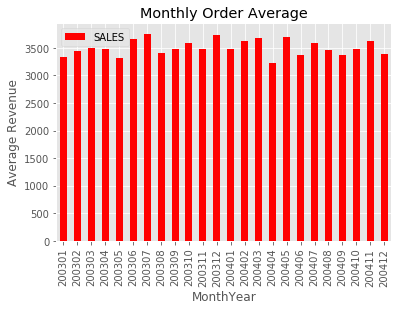

In [18]:
average_revenue = dat.groupby('YEAR_MONTH')['SALES'].mean().reset_index()
average_revenue
average_revenue.plot(kind='bar', color= 'Red', x='YEAR_MONTH', y='SALES')
plt.title('Monthly Order Average')
plt.xlabel('MonthYear')
plt.ylabel('Average Revenue')
plt.xticks(rotation=90)
plt.show()

Unlike the monthly active customer and monthly order count, the average revenue per order in March 2004 did not decline.

### New Customer Growth Rate

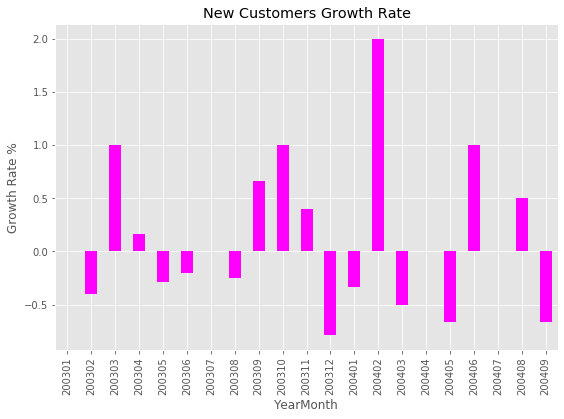

In [19]:
plt.figure(figsize=(9,6))
dat_first_purchase = dat.groupby('CUSTOMERNAME').YEAR_MONTH.min().reset_index()
dat_first_purchase.columns = ['CUSTOMERNAME','FirstPurchaseDate']
dat_first_purchase.groupby(['FirstPurchaseDate'])['CUSTOMERNAME'].nunique().pct_change().plot(kind='bar', 
                                                                                              color='Magenta')
plt.title('New Customers Growth Rate')
plt.xlabel('YearMonth')
plt.ylabel('Growth Rate %')
plt.show()

We see that February 2004 saw the highest growth rate. 

---

# Part 2: Customer Segmentation

I will be using RFM segmentation method here. Recall,

**Recency:** Recency is the number of days between the customer's latest order date and the snapshot date.

**Frequency:** Number of purchases made by the customer over a time period.

**MonetaryValue:** Revenue generated by the customer.

In [20]:
snapshot_date = dat['ORDERDATE'].max() + dt.timedelta(days=1)
dat_rfm = dat.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE': lambda x: (snapshot_date - x.max()).days,
    'ORDERNUMBER': 'count','SALES':'sum'})

dat_rfm.rename(columns={'ORDERDATE': 'Recency',
                   'ORDERNUMBER': 'Frequency',
                   'SALES': 'MonetaryValue'}, inplace=True)

In [21]:
dat_rfm.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",31,51,157807.81
Alpha Cognac,406,15,55349.32
Amica Models & Co.,100,26,94117.26
"Anna's Decorations, Ltd",410,27,88983.71
Atelier graphique,23,7,24179.96


#### To assign RFM score, let's create a spend quartile with 5 groups.

In [22]:
Recency_quartile = pd.qcut(dat_rfm['Recency'], q=4, labels=list(range(4,0,-1)))
Frequency_quartile = pd.qcut(dat_rfm['Frequency'], q=4, labels=range(1,5))
MonetaryValue_quartile = pd.qcut(dat_rfm['MonetaryValue'], q=4, labels=range(1,5))

# Assign the quartile values to the Spend_Quartile column
dat_rfm['R'] = Recency_quartile
dat_rfm['F'] = Frequency_quartile
dat_rfm['M'] = MonetaryValue_quartile

dat_rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M
CUSTOMERNAME,,,,,,
"AV Stores, Co.",31,51,157807.81,4,4,4
Alpha Cognac,406,15,55349.32,1,1,1
Amica Models & Co.,100,26,94117.26,2,3,3
"Anna's Decorations, Ltd",410,27,88983.71,1,3,3
Atelier graphique,23,7,24179.96,4,1,1


In [23]:
# Calculate RFM_Score
dat_rfm['RFM_Score'] = dat_rfm[['R','F', 'M']].sum(axis=1)
dat_rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",31,51,157807.81,4,4,4,12.0
Alpha Cognac,406,15,55349.32,1,1,1,3.0
Amica Models & Co.,100,26,94117.26,2,3,3,8.0
"Anna's Decorations, Ltd",410,27,88983.71,1,3,3,7.0
Atelier graphique,23,7,24179.96,4,1,1,6.0


#### Let's label the customers based on RFM_Score.
1. High Value Customer: RFM_Score > 10 
2. Mid Value Customer: RFM_SCore < 10 & RFM_Score >= 6 
3. Low Value Customer: RFM Score < 6 

In [24]:
# Define rfm_level function
def rfm_level(dat):
    if np.bool(dat['RFM_Score'] >= 10):
        return 'High Value Customer'
    elif np.bool((dat['RFM_Score'] < 10) & (dat['RFM_Score'] >= 6)):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'

# Create a new variable RFM_Level
dat_rfm['RFM_Level'] = dat_rfm.apply(rfm_level, axis=1)

dat_rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",31,51,157807.81,4,4,4,12.0,High Value Customer
Alpha Cognac,406,15,55349.32,1,1,1,3.0,Low Value Customer
Amica Models & Co.,100,26,94117.26,2,3,3,8.0,Mid Value Customer
"Anna's Decorations, Ltd",410,27,88983.71,1,3,3,7.0,Mid Value Customer
Atelier graphique,23,7,24179.96,4,1,1,6.0,Mid Value Customer


Let's see the mean and size of each RFM_Level below:

In [25]:
rfm_level_agg = dat_rfm.groupby(['RFM_Level']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue':['mean','count']}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

                    Recency Frequency MonetaryValue      
                       mean      mean          mean count
RFM_Level                                                
High Value Customer    44.5      41.4      147357.7    28
Low Value Customer    248.4      13.7       47340.5    26
Mid Value Customer    116.9      21.8       75901.9    38


### Extract 'Feature matrix' and 'Target array'

In [26]:
# Extract Feature Matrix
X_data = dat_rfm.drop('RFM_Level', axis=1)
X_data.shape

(92, 7)

In [27]:
# Extract the target array
y_data = dat_rfm['RFM_Level']
y_data.shape

(92,)

### Dimensionality Reduction
Dimensionality reduction facilitates visualizing higher dimensional data in fewer dimension. 

In [28]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X_data)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(X_data)         # 4. Transform the data to two dimensions

Now let's plot the results.

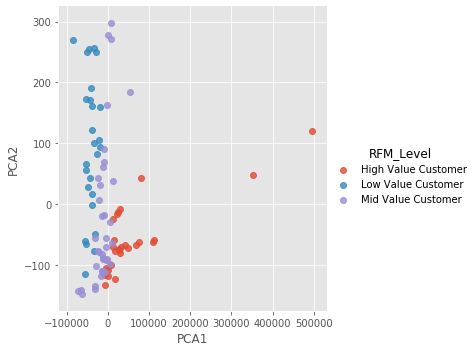

In [29]:
dat_rfm['PCA1'] = X_2D[:, 0]
dat_rfm['PCA2'] = X_2D[:, 1]
sns.lmplot("PCA1", "PCA2", hue='RFM_Level', data=dat_rfm, fit_reg=False)

We see that in the 2-dimensional representation, the RFM_Level are fairly separated, even though the PCA algorithm had no knowledge of the RFM_Level labels.

## Gaussian Mixture Model (GMM) Clustering

In [30]:
from sklearn.mixture import GaussianMixture 
model = GaussianMixture(n_components=3, covariance_type='full')         
model.fit(X_data)               
y_gmm = model.predict(X_data)

I will add the cluster label to the dat_rfm dataframe and plot the results.

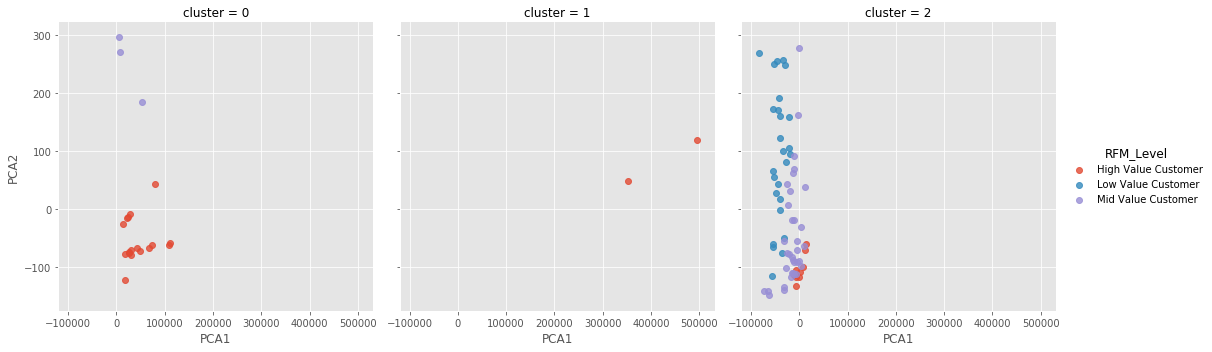

In [31]:
dat_rfm['cluster'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=dat_rfm, hue='RFM_Level', col='cluster', fit_reg=False)

By splitting the data by cluster number, we see that the GMM algorithm has recovered the underlying labels fair enough.

---

## K-Means Clustering

#### Choosing the number of clusters using Elbow method

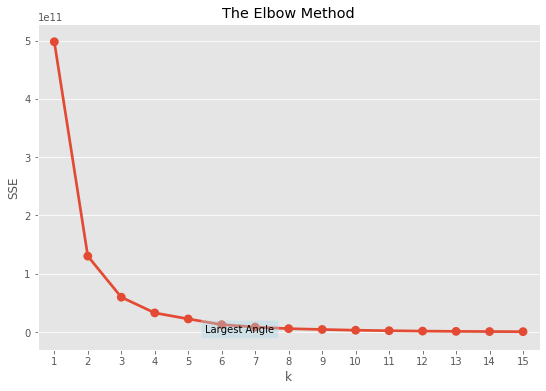

In [32]:
# Fit KMeans and calculate SSE for each k
sse={}
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_data)
    sse[k] = kmeans.inertia_ 
    
plt.figure(figsize=(9,6))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.text(4.5,50,"Largest Angle",bbox=dict(facecolor='lightblue', alpha=0.4))
plt.show()

#### Run K-Means with 5 clusters

In [33]:
kmeans = KMeans(n_clusters=5, random_state=1)  
kmeans.fit(X_data)                                   
cluster_labels = kmeans.labels_
data_rfm2 = X_data.assign(Cluster=cluster_labels)
data_rfm2.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,Cluster
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",31,51,157807.81,4,4,4,12.0,2
Alpha Cognac,406,15,55349.32,1,1,1,3.0,0
Amica Models & Co.,100,26,94117.26,2,3,3,8.0,3
"Anna's Decorations, Ltd",410,27,88983.71,1,3,3,7.0,3
Atelier graphique,23,7,24179.96,4,1,1,6.0,0


Let's see the average RFM values and segment sizes per cluster.

In [34]:
grouped = data_rfm2.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         192.1      14.1       47934.2    36
1           8.0     122.0      441602.4     1
2          75.9      46.0      162742.4     8
3         100.1      25.6       91010.3    46
4           8.0     170.0      585495.9     1

We can clearly see lower recency corresponds to higher frequency and hence higher monetary value and the vice versa. 

---